In [9]:
from sdm.utils import set_project_wd
from sdm.data.os import generate_parquets
from sdm.geo import reproject_to_model_raster
import geopandas as gpd
import xarray as xr
from tempfile import NamedTemporaryFile
from sdm.geo import rasterise_gdf
import rioxarray as rxr


set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


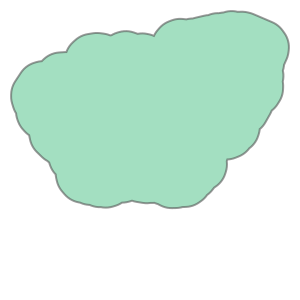

In [10]:
boundary = gpd.read_file("data/processed/boundary.geojson")
# Buffer the boundary by a few kms
boundary["geometry"] = boundary.geometry.buffer(7000)
boundary.geometry[0]

In [11]:
datasets=["Building", "Water", "Woodland", "Road" ]
paths = generate_parquets(datasets, boundary = boundary.geometry[0], dir="data/raw/big-files/os-data", overwrite=False)

os_data = {name:gpd.read_parquet(path) for name, path in zip(datasets, paths)}

All datasets have parquet files already. Set overwrite = True to overwrite them


<Axes: >

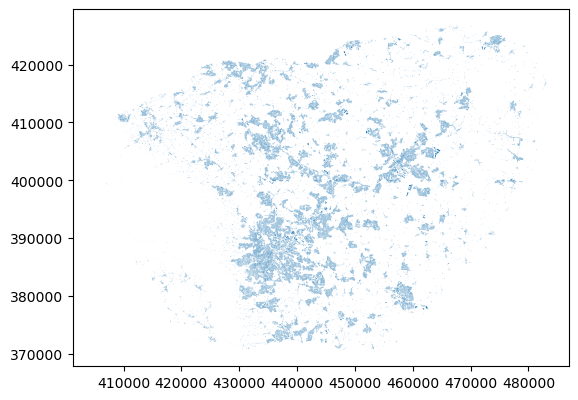

In [12]:
os_data["Building"].plot()

# Tidy Up the OS Datasets

## Major & Minor Roads

Classify the roads into major and minor roads which have different effects on bats. Major roads tend to deter bats and pose a collision risk. Minor roads can have a positive effect where they are associated with vegetation or lighting which can aid in foraging.

In [13]:
os_data["Road"].head()

,ID,FEATCODE,geometry,DISTNAME,ROADNUMBER,CLASSIFICA,DRAWLEVEL,OVERRIDE,dataset
123330,BB2AE453-31E7-4C79-890D-0B4828712FD0,25750.0,"LINESTRING Z (430252.000 420328.000 0.000, 430...",Broadway,None,Minor Road,0,F,Road
123147,422E3AC5-7D1B-4C00-B26A-2D4B91A62FF8,25760.0,"LINESTRING Z (430375.120 420419.350 0.000, 430...",None,None,Local Street,0,F,Road
123331,4BDB6E9B-657B-4FA9-A874-2C77E8BE0568,25750.0,"LINESTRING Z (430244.000 420341.000 0.000, 430...",Broadway,None,Minor Road,0,F,Road
123332,F52712FA-78C5-416E-8B53-EE50AB751D52,25750.0,"LINESTRING Z (430233.340 420359.090 0.000, 430...",Broadway,None,Minor Road,0,F,Road
123333,79181D80-4A7D-47D3-AF98-76B12468425F,25760.0,"LINESTRING Z (430244.000 420341.000 0.000, 430...",None,None,Local Street,0,F,Road


This code gets the unique road classifications and generates a true false variable if they match a regex pattern It is done on the unique values as this operation is faster and it takes advantage of the fast joins in pandas to broadcast the values across the entire series.

In [14]:
# Get Classes
road_classes = os_data["Road"]["CLASSIFICA"].value_counts()
major_roads = ["Motorway", "A Road"]
pattern =  "|".join([road_type + "*" for road_type in major_roads])
road_classes = road_classes.to_frame(name = "count").reset_index(names=["CLASSIFICA"])
# Match the pattern
road_classes["major_road"] = road_classes.CLASSIFICA.str.contains(pattern, regex=True)
road_classes.drop(axis = 1, labels = ["count"],  inplace=True)

# Join and broadcast the data
roads = gpd.GeoDataFrame(os_data["Road"].merge(
    road_classes, on = "CLASSIFICA", how="left"
))
major_roads = roads[roads.major_road == True]
minor_roads = roads[roads.major_road == False]

Compose a list of datasets to be rasterised and have cover calculated

In [15]:
feature_gdfs = {
    "major_roads" : major_roads,
    "minor_roads" : minor_roads,
    "woodland" : os_data["Woodland"],
    "water" : os_data["Water"],
    "buildings" : os_data["Building"]
}

# Rasterize & Calculate Cover

In [16]:
import numpy as np

def calculate_cover(gdf, name="cover", target_resolution:int=100):
    with NamedTemporaryFile() as f:
        rasterise_gdf(gdf, resolution=1, output_file=f.name, bbox = boundary.geometry[0].bounds)
        # Load the cover raster
        cover = rxr.open_rasterio(f.name, chunks="auto")
        cover_area = cover.coarsen(x=target_resolution, y = target_resolution, boundary="trim").sum().compute()
            
    return cover_area.to_dataset(name=name)

cover_datasets = [calculate_cover(gdf, name, target_resolution=100) for name, gdf in feature_gdfs.items()]

/var/folders/vm/9ws15vws62zgnr64rdr_ls5r0000gn/T/ipykernel_44396/3212099116.py:8: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  cover_area = cover.coarsen(x=target_resolution, y = target_resolution, boundary="trim").sum().compute()
/var/folders/vm/9ws15vws62zgnr64rdr_ls5r0000gn/T/ipykernel_44396/3212099116.py:8: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     a

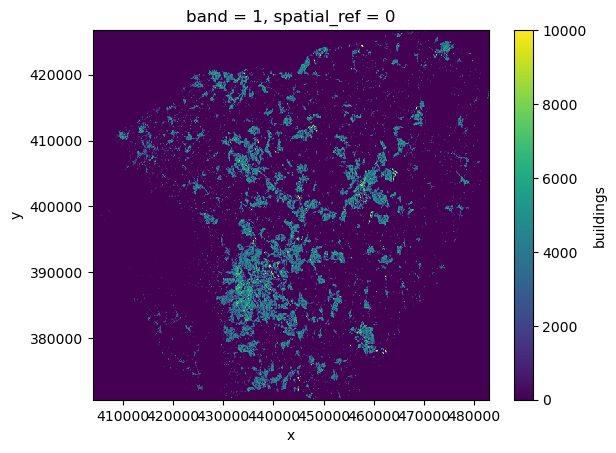

In [17]:
feature_cover = xr.merge(cover_datasets)
feature_cover.buildings.plot()

In [18]:
# Mask the data
import numpy as np
feature_cover_clipped =  feature_cover.rio.clip([boundary.geometry[0]], crs = boundary.crs)

Tidy up for writing a file

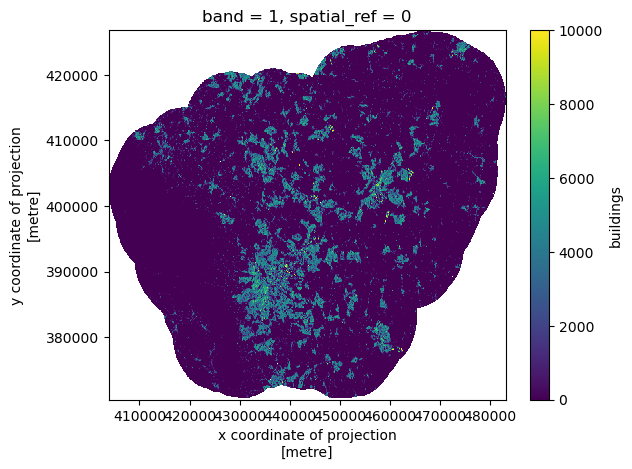

In [28]:
feature_cover_clipped = feature_cover_clipped.where(feature_cover_clipped != 255, np.nan)
feature_cover_clipped = feature_cover_clipped.squeeze()
feature_cover_clipped.buildings.plot()

In [20]:
feature_cover_clipped = reproject_to_model_raster(feature_cover_clipped)
feature_cover_clipped.rio.to_raster("data/evs/os-feature-cover-100m.tif")

# Distance Matrixes

## Create the Point Grid

In [29]:
# Create a grid of points
import geopandas as gpd
from sdm.geo import generate_point_grid
bbox = tuple(boundary.total_bounds)
resolution = 100
boundary_grid = generate_point_grid(bbox, resolution, crs = boundary.crs)
boundary_grid["x"] = boundary_grid.geometry.x
boundary_grid["y"] = boundary_grid.geometry.y
boundary_grid.head()

,geometry,x,y
0,POINT (403864.879 370493.562),403864.879459,370493.561784
1,POINT (403964.879 370493.562),403964.879459,370493.561784
2,POINT (404064.879 370493.562),404064.879459,370493.561784
3,POINT (404164.879 370493.562),404164.879459,370493.561784
4,POINT (404264.879 370493.562),404264.879459,370493.561784


## Create the Feature Points

In [30]:
# Convert the feature cover to a dataframe.
# Get the points which are >0 (there is feature cover)
# Then convert to a geo dataframe of points
cover_df = feature_cover_clipped.to_dataframe()
cover_df.drop(axis=1, labels=["spatial_ref", "band"], inplace=True)
cover_df = cover_df.stack().reset_index()
cover_df.columns = ["y", "x",  "feature", "cover"]
cover_df = cover_df[cover_df.cover > 0]

cover_df = gpd.GeoDataFrame(cover_df, geometry=gpd.points_from_xy(cover_df.x, cover_df.y), crs = boundary.crs)

cover_df.head()

,y,x,feature,cover,geometry
4,426696.051974,466057.544378,buildings,176.0,POINT (466057.544 426696.052)
8,426696.051974,466157.613081,water,370.0,POINT (466157.613 426696.052)
13,426696.051974,466257.681785,water,613.0,POINT (466257.682 426696.052)
18,426696.051974,466357.750488,water,638.0,POINT (466357.750 426696.052)
22,426696.051974,466457.819192,woodland,1426.0,POINT (466457.819 426696.052)


### Calculate the Distance Matrix

In [31]:
from scipy.spatial import cKDTree
import numpy as np

grid_points = np.array(boundary_grid[["x", "y"]])

# For every point in the grid, get the distance to the nearest feature point
def get_shortest_distance(grid_xy, feature_xy):
    tree = cKDTree(feature_xy)
    dist, idx = tree.query(grid_xy, k=1)
    return dist

# Loop through the features and get the distance to the nearest feature point
distance_to_feature = {}
for feature in cover_df.feature.unique():
    feature_points = np.array(cover_df[cover_df.feature == feature][["x", "y"]])
    boundary_grid[f"distance_to_{feature}"] = get_shortest_distance(grid_points, feature_points)

boundary_grid.head()

,geometry,x,y,distance_to_buildings,distance_to_water,distance_to_woodland,distance_to_minor_roads,distance_to_major_roads
0,POINT (403864.879 370493.562),403864.879459,370493.561784,15065.691698,15429.917488,15163.306336,15104.964073,16726.749453
1,POINT (403964.879 370493.562),403964.879459,370493.561784,14975.085897,15344.723968,15075.942599,15015.928157,16660.210744
2,POINT (404064.879 370493.562),404064.879459,370493.561784,14884.600394,15259.710142,14988.736821,14927.031090,16594.007859
3,POINT (404164.879 370493.562),404164.879459,370493.561784,14794.237396,15174.879030,14901.691773,14838.275368,16528.144832
4,POINT (404264.879 370493.562),404264.879459,370493.561784,14703.999164,15090.233714,14814.810290,14749.663543,16462.625743


### Convert to xarray

In [32]:
# Order the points in the grid by coordinates then convert it to an xr dataset
boundary_grid = boundary_grid.sort_values(["y", "x"])
boundary_grid = boundary_grid.set_index(["y", "x"])
distance_array = boundary_grid.to_xarray()
# Set the crs
distance_array = distance_array.rio.write_crs(boundary.crs)
# Clip to the boundary to reduce edge effects
distance_array = distance_array.rio.clip([boundary.geometry[0]], crs = boundary.crs)
# Drop the geometry variable in the xarray dataset
distance_array = distance_array.drop_vars(["geometry"])

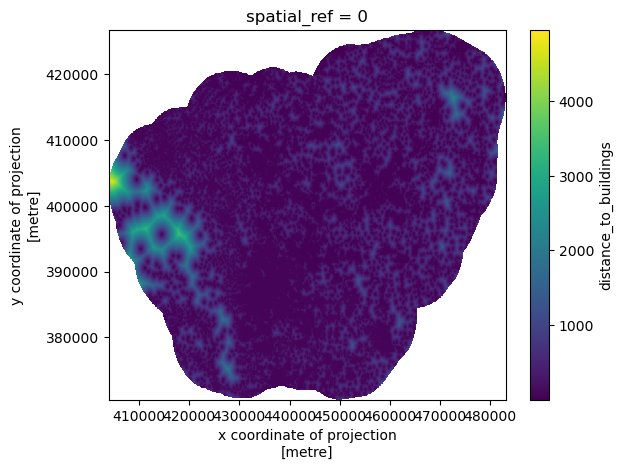

In [33]:
distance_array.distance_to_buildings.plot()

In [34]:
distance_array = reproject_to_model_raster(distance_array)
distance_array.rio.to_raster("data/evs/os-distance-to-feature.tif")